# Aprendizagem Computacional II
# Projeto - UrbanSound8K

**Projeto desenvolvido por:** \
    Beatriz Fonseca - up202205826 \
    Inês Neves - up202206252 \
    Maria Beatriz Moreira - up202208293 


# Introdução

O objetivo deste projeto é aplicar os conhecimentos adquiridos ao longo do curso para resolver um problema real. Neste caso, o problema é a classificação de sons do dataset UrbanSound8K.

Este problema de classificação consiste em categorizar excertos de áudio em classes distintas com base nas suas características acústicas. O conjunto de dados UrbanSound8K contém 8732 excertos de som (com duração de até 4 segundos) classificados em 10 categorias: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, e street_music. O objetivo é desenvolver classificadores capazes de identificar corretamente a categoria de um excerto de som desconhecido.

Para resolver este problema, optamos por utilizar dois classificadores: o MLP (Multilayer Perceptron) e a CNN (Convolutional Neural Network).

# Análise Exploratória dos Dados

In [ ]:
import os
import pickle
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import soundfile as sf
from pydub import AudioSegment
import matplotlib.pyplot as plt

In [ ]:
meta = pd.read_csv(r'C:\\Users\\InesNeves\\Desktop\\AC_II\\Projeto_ACII\\UrbanSound8K\\metadata\\UrbanSound8K.csv')

In [4]:
meta

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


Distribuição de cada classe no Dataset

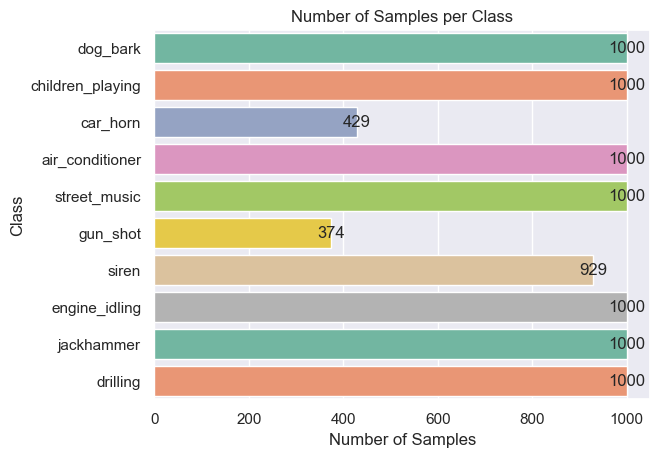

In [5]:
sns.set(style="darkgrid")
ax = sns.countplot(y=meta['class'], orient='v', palette='Set2')

plt.title('Number of Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class')

for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), ha='center', va='center')

plt.show()

Verificamos que as classes *car_horn* e *gun_shot* são minoritárias, face às restantes.

Distribuição de cada classe por fold

In [6]:
class_folds = []
for i in range(1,11):
    class_folds.append(meta[meta.fold == i]['class'].value_counts())

class_dist= pd.DataFrame(class_folds)
class_dist = class_dist.reset_index()
class_dist['index'] = ["fold"+str(x) for x in range(1,11)]

In [7]:
class_dist

,index,jackhammer,drilling,street_music,dog_bark,children_playing,air_conditioner,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


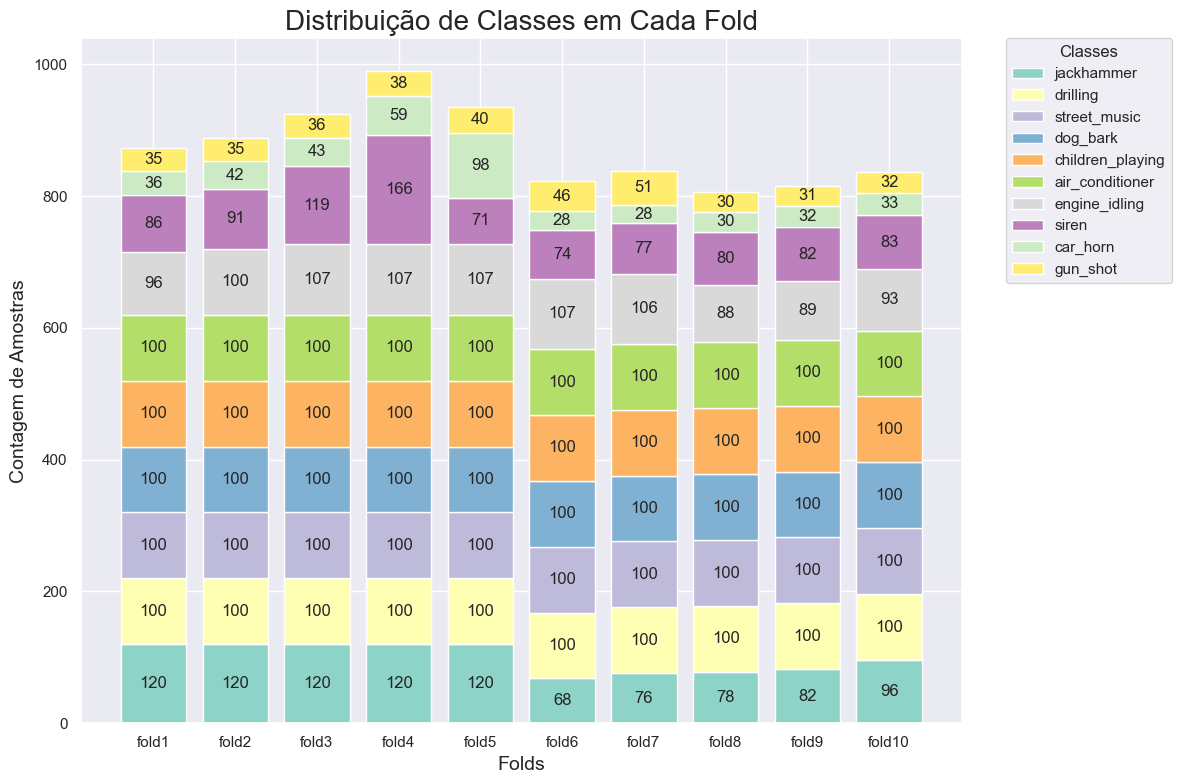

In [ ]:
#Criar DataFrame a partir de class_distribution
df = pd.DataFrame(class_dist)

folds = df['index']
classes = df.columns[1:]

plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, 10))

#Criar um gráfico de barras empilhadas
for i, class_name in enumerate(classes):
    if i == 0:
        plt.bar(folds, df[class_name], label=class_name, color=colors[i])
    else:
        plt.bar(folds, df[class_name], bottom=df[classes[:i]].sum(axis=1), 
                label=class_name, color=colors[i])

plt.title('Distribuição de Classes em Cada Fold', fontsize=20)
plt.xlabel('Folds', fontsize=14)
plt.ylabel('Contagem de Amostras', fontsize=14)

for i in range(len(folds)):
    total_height = 0
    for class_name in classes:
        total_height += df[class_name].iloc[i]
        plt.text(i, total_height - df[class_name].iloc[i] / 2, 
                 df[class_name].iloc[i], ha='center', va='center')

plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout() 
plt.show()

In [ ]:
def check_files(metadata_file, fold_files):
    metadata = metadata_file
    
    metadata_files = metadata['slice_file_name'].tolist()
    
    fold_files = [file for file in fold_files if file.endswith('.wav')]
    
    for file in fold_files:
        if file not in metadata_files:
            return f'The file {file} is not present in the metadata'
    
    return 'All the files in the folds are present in the metadata'

In [6]:
path_sound = r"C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio"

Verificar se existem valores nulos nos dados

In [ ]:
fold_files = []
for i in range(1, 11):
    fold_path = os.path.join(path_sound, f'fold{i}')
    fold_files += os.listdir(fold_path)

#Verificar se todos os ficheiros nos folds estão presentes nos metadata
print(check_files(meta, fold_files))

#Verificar se o dataset tem valores nulos
print(meta.isnull().sum())

All the files in the folds are present in the metadata
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


# Características do Áudio

*Taxa de Amostragem, Profundidade de Bits e Duração*

A taxa de amostragem e a profundidade de bits são fundamentais na digitalização de sinais de áudio, estando relacionadas à conversão de analógico para digital. A taxa de amostragem define a frequência com que são feitas as amostras, enquanto a profundidade de bits define o nível de detalhe das amostras.

Para uniformizar os dados vamos escolher os valores mais comuns.

# Taxa de Amostragem nos Dados

In [ ]:
sample_rates = {}

for i in range(1, 11):
    path_f = os.path.join(path_sound, f"fold{i}")
    files = librosa.util.find_files(path_f)
    for filename in files:
        if filename.endswith(".wav"):
            sr = librosa.get_samplerate(filename)
            if sr in sample_rates:
                sample_rates[sr] += 1
            else:
                sample_rates[sr] = 1

print(f'The Sample rate most common is  {max(sample_rates, key=sample_rates.get)} Hz')


The Sample rate most common is  44100 Hz


# Profundidade de Bits nos Dados

In [ ]:
bit_depths = {}

for i in range(1, 11):  
    fold_path = os.path.join(path_sound, f"fold{i}")
    files = librosa.util.find_files(path_f)
    for filename in files:
        if filename.endswith(".wav"):
            info = sf.info(filename)
            bit_depth = info.subtype[-2:]
            
            if bit_depth in bit_depths:
                bit_depths[bit_depth] += 1
            else:
                bit_depths[bit_depth] = 1
                
max_bit_depth = max(bit_depths, key=bit_depths.get)
print(f'The most common bit depth is {max_bit_depth} bits')

The most common bit depth is 16 bits


# Duração dos Dados

In [ ]:
durations = []
for i in range(1, 11): 
    fold_path = os.path.join(path_sound, f"fold{i}")
    files = librosa.util.find_files(path_f)
    for filename in files:
        if filename.endswith(".wav"):
            y, sr = librosa.load(filename, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)

average_duration = sum(durations) / len(durations) 
max_duration = max(durations) 
min_duration = min(durations) 

print(f'The average length of the audios is {average_duration:.2f} seconds.')
print(f'The maximum length of the audios is {max_duration:.2f} seconds.')
print(f'The minimum length of the audios is {min_duration:.2f} seconds.')

The average length of the audios is 3.63 seconds.
The maximum length of the audios is 4.00 seconds.
The minimum length of the audios is 0.24 seconds.


# Distribuição da duração do som

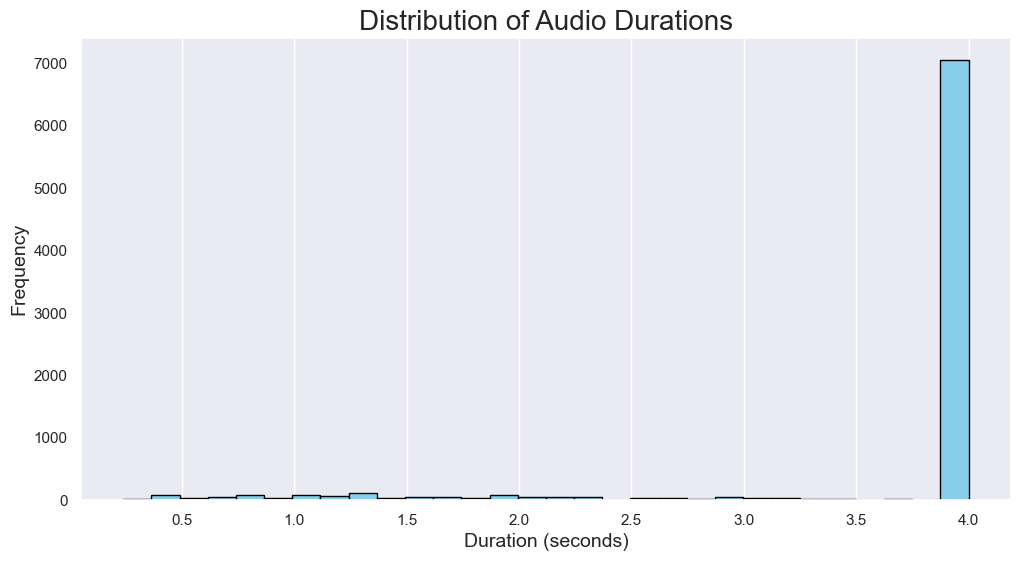

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Durations', fontsize=20)
plt.xlabel('Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualização de Features de um Som

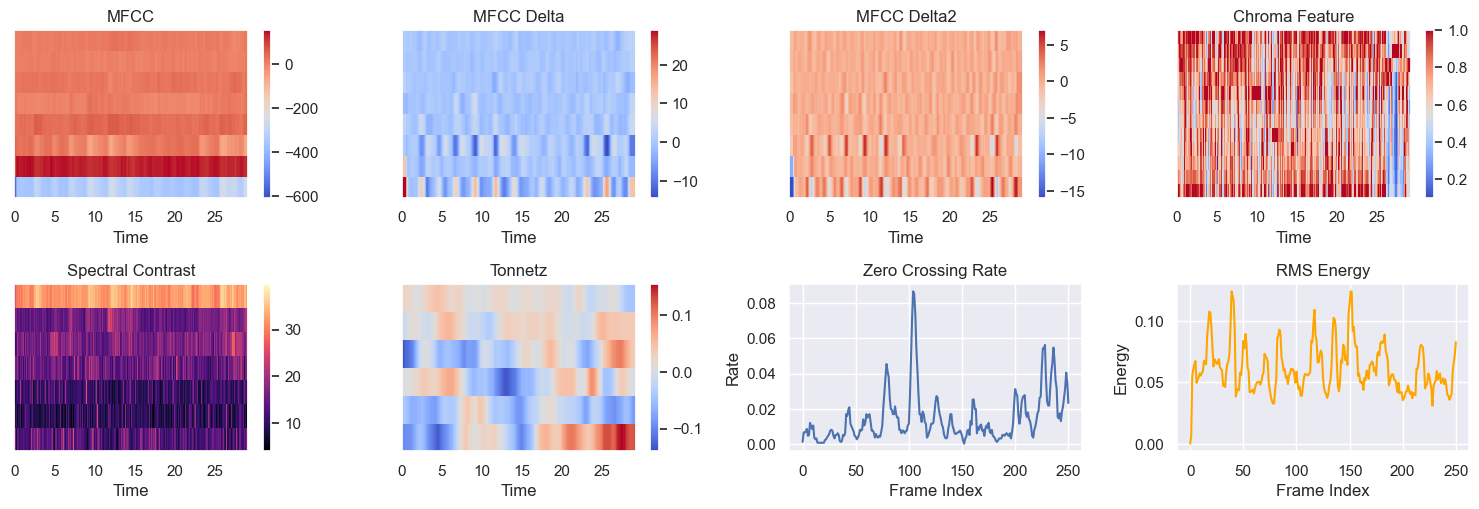

In [17]:
y, sr = librosa.load(r'C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold2\18581-3-0-0.wav', sr=None)

#Extrair as features 
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
rms = librosa.feature.rms(y=y)

#Plot das features
plt.figure(figsize=(15, 20))

#Plot MFCC
plt.subplot(8, 4, 1)
librosa.display.specshow(mfcc, sr=4410, x_axis='time')
plt.colorbar()
plt.title('MFCC')

#Plot MFCC Delta
plt.subplot(8, 4, 2)
librosa.display.specshow(mfcc_delta, sr=4410, x_axis='time')
plt.colorbar()
plt.title('MFCC Delta')

#Plot MFCC Delta2
plt.subplot(8, 4, 3)
librosa.display.specshow(mfcc_delta2, sr=4410, x_axis='time')
plt.colorbar()
plt.title('MFCC Delta2')

#Plot Chroma
plt.subplot(8, 4, 4)
librosa.display.specshow(chroma, sr=4410, x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma Feature')

#Plot Spectral Contrast
plt.subplot(8, 4, 5)
librosa.display.specshow(spectral_contrast, sr=4410, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

#Plot Tonnetz
plt.subplot(8, 4, 6)
librosa.display.specshow(tonnetz, sr=4410, x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.title('Tonnetz')

#Plot Zero Crossing Rate
plt.subplot(8, 4, 7)
plt.plot(zero_crossing_rate[0])
plt.title('Zero Crossing Rate')
plt.xlabel('Frame Index')
plt.ylabel('Rate')

#Plot RMS
plt.subplot(8, 4, 8)
plt.plot(rms[0], color='orange')
plt.title('RMS Energy')
plt.xlabel('Frame Index')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

Com base na imagem anterior, decidimos extrair as *features* **MFCC**, **MFCC Delta** e **MFCC Delta2** para o nosso projeto.

As MFCCs, MFCC delta e MFCC delta2 são boas *features* porque capturam informações essenciais do áudio:

- MFCCs: Representam as características de timbre e textura do som, refletindo como o ouvido humano percebe o áudio.
- MFCC Delta: Captura as mudanças no tempo, mostrando como as características do som variam.
- MFCC Delta2: Mostra a aceleração dessas mudanças, ajudando a identificar variações rápidas.

Essas *features* são compactas e eficazes para representar o áudio.

# Pré-Processamento dos Dados

A partir da nossa função de *pre_processing* garantimos o seguinte:

 - Profundidade de bits: O áudio tem para uma profundidade de 16 bits.
 - Duração: O áudio tem exatamente 4 segundos. Se o áudio for mais curto, ele é repetido até atingir esse tempo, e se for maior, é cortado para 4 segundos. 
 - Normalização: Após a extração das features (MFCC, delta e delta2), o áudio é normalizado para garantir que os valores das features estejam numa escala uniforme.

Assim, a função prepara os arquivos de áudio, garantindo que tenham a mesma duração, qualidade (profundidade de bits) e que as features extraídas sejam normalizadas.

In [ ]:
def pre_procesing(files, csr, sons_meta):
    pad_ms = 4000  #Duração fixa dos áudios em milissegundos
    data = []
    label = []
    counter = 0

    for f in files:
        if f.endswith(".wav"):
            #Leitura do ficheiro e escrita num caminho temporário
            nf, sr = sf.read(f)
            new_path = "new"
            sf.write(new_path, nf, sr, format="wav")

            #Carregar e padronizar o áudio usando pydub
            audio = AudioSegment.from_file(new_path, format="wav")
            audio = audio.set_sample_width(2)

            #Verificar a duração do áudio e, se for menor que 4 segundos, repetir até atingir 4s
            while len(audio) < pad_ms:
                audio += audio  

            #Cortar o áudio para exatamente 4 segundos
            audio = audio[:pad_ms]

            #Exportar o áudio padronizado temporariamente
            audio.export(new_path, format='wav')
            
            #Carregar o áudio processado com librosa
            y, sr = librosa.load(new_path, sr=csr, duration=4.0)
            
            #Extração das features
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

            #Combinar todas as features num array
            features_combined = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
            
            #Normalizar o array combinado
            features_combined = librosa.util.normalize(features_combined)
            
            #Guardar os dados e a etiqueta correspondente
            label.append(sons_meta.loc[os.path.basename(f)][-1])
            data.append(features_combined)
            
            counter += 1
    
    return data, label

In [4]:
path_meta = r"C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\metadata\UrbanSound8K.csv"
sons =pd.read_csv(path_meta)

sons= sons.set_index("slice_file_name")
sons.loc['100032-3-0-0.wav'][-1]

'dog_bark'

In [7]:
dataset=[]
for i in range(10):
    root= path_sound + "\\fold" + str(i+1)
    print(root)
    files= librosa.util.find_files(root)
    data,label=pre_procesing(files,44100,sons)
    dataset.append([data,label])
    print("fold "+str(i+1)+" done")

C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold1
fold 1 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold2
fold 2 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold3
fold 3 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold4
fold 4 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold5
fold 5 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold6
fold 6 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold7
fold 7 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold8
fold 8 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold9
fold 9 done
C:\Users\InesNeves\Desktop\AC_II\Projeto_ACII\UrbanSound8K\audio\fold10
fold 10 done


# Extração de *features* a serem usadas pelos modelos MLP e CNN

Este código prepara os dados de áudio para serem usados nos dois tipos de modelos: CNN e MLP, que escolhemos utilizar.

Para a **CNN**: As features (MFCC, Delta e Delta2) são empilhadas ao longo do eixo dos canais (3 canais no total) e organizadas numa matriz 3D com a forma (3, 13, T). Nesta matriz, 3 representa os três tipos de características (MFCC, Delta e Delta2), 13 são os coeficientes para cada tipo e T é o número de frames no áudio.

Para o **MLP**: As features são transformadas num vetor 1D, calculando a média das características ao longo do eixo do tempo (T). Tal é feito com o intuito de  reduzir a dimensionalidade, mantendo as informações principais para cada tipo de característica (MFCC, Delta e Delta2).

Por fim, os dados processados são guardados em arquivos .pkl para serem usados posteriormente [*datset_cnn.pkl* (13 coeficientes), *dataset_cnn_8.pkl* (8 coeficientes), *dataset_mlp.pkl*(13 coeficientes) e *dataset_mlp_8.pkl* (8 coeficientes)].

Optamos por realizar todas as experiências no treino de ambos os modelos para features com 13 coeficientes e features com 8 coeficientes. Para isso, foram guardados os 4 arquivos .pkl referidos anteriormente (2 datasets para serem utilizados por cada modelo).

A escolha de 13 coeficientes é justificada pelo facto de ser comum utilizar 13 coeficientes para MFCC, uma vez que estes capturam a maior parte das informações importantes sobre o áudio (como a tonalidade e a estrutura espectral), sendo amplamente utilizados em reconhecimento de fala.

Já a escolha de utilizar 8 coeficientes foi planeada com o objetivo de simplificar as features, preservando os elementos essenciais dos dados, enquanto se reduzia a complexidade do modelo.

Essa combinação garante uma boa representação do áudio, facilitando o processamento nos modelos sem perder informações importantes para a classificação.

# 13 Coeficientes

In [ ]:
dataset_cnn = []
dataset_mlp = []

for fold_data, fold_labels in dataset:
    data_cnn = []
    data_mlp = []

    for features_combined in fold_data:
        #Para a CNN: "Stack" (empilha) MFCC, MFCC Delta, MFCC Delta2 no eixo de canal
        #Transforma a matriz 3D para formato (3, 13, T), onde 3 representa os canais (MFCC, Delta, Delta2)
        features_stacked = np.stack([features_combined[:13],  # MFCC (13 coeficientes)
                                     features_combined[13:26],  # Delta (13 coeficientes)
                                     features_combined[26:39]])  # Delta2 (13 coeficientes)

        #Formato final da entrada para a CNN: (3, 13, T)
        data_cnn.append(features_stacked)

        #Para a MLP: Calcula a média ao longo do eixo do tempo (T) para cada canal (MFCC, Delta, Delta2)
        mfcc_mean = np.mean(features_combined[:13], axis=1)
        delta_mean = np.mean(features_combined[13:26], axis=1)
        delta2_mean = np.mean(features_combined[26:39], axis=1)

        features_mlp = np.concatenate([mfcc_mean, delta_mean, delta2_mean])
        data_mlp.append(features_mlp)

    #Adiciona o fold formatado para a lista completa do dataset
    dataset_cnn.append([data_cnn, fold_labels])
    dataset_mlp.append([data_mlp, fold_labels])

#Guarda o dataset da CNN e MLP
with open('dataset_cnn.pkl', 'wb') as file:
    pickle.dump(dataset_cnn, file)
with open('dataset_mlp.pkl', 'wb') as file:
    pickle.dump(dataset_mlp, file)


# 8 coeficientes

In [ ]:
dataset_cnn = []
dataset_mlp = []

#Loop sobre os folds para formatar as features
for fold_data, fold_labels in dataset:
    data_cnn = []
    data_mlp = []

    for features_combined in fold_data:
        #Para a CNN: "Stack" (empilha) MFCC, MFCC Delta, MFCC Delta2 no eixo de canal
        #Transforma a matriz 3D para formato (3, 8, T), onde 3 representa os canais (MFCC, Delta, Delta2)
        features_stacked = np.stack([features_combined[:8],  # MFCC (8 coeficientes)
                                     features_combined[8:16],  # Delta (8 coeficientes)
                                     features_combined[16:24]])  # Delta2 (8 coeficientes)

        data_cnn.append(features_stacked)

        #Para a MLP: Calcula a média ao longo do eixo do tempo (T) para cada canal (MFCC, Delta, Delta2)
        mfcc_mean = np.mean(features_combined[:8], axis=1)
        delta_mean = np.mean(features_combined[8:16], axis=1)
        delta2_mean = np.mean(features_combined[16:24], axis=1)

        features_mlp = np.concatenate([mfcc_mean, delta_mean, delta2_mean])
        data_mlp.append(features_mlp)

    #Adiciona o fold formatado para a lista completa do dataset
    dataset_cnn.append([data_cnn, fold_labels])
    dataset_mlp.append([data_mlp, fold_labels])

#Guarda o dataset da CNN e MLP
with open('dataset_cnn_8.pkl', 'wb') as file:
    pickle.dump(dataset_cnn, file)
with open('dataset_mlp_8.pkl', 'wb') as file:
    pickle.dump(dataset_mlp, file)